In [20]:
import qutip as qt
import numpy as np

# Tracking info of simulations 
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

In [21]:
import sys
sys.path.append('/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/quantum_state_transfer/src')

import model_building as md
import Hamiltonian as Ham
import dynamics as dyn
import data_handling as dh
import plots as plots



# Initial test

In [22]:
# Define parameters
N=10
lmd = 0.02272
J = 0.5
state_dictionary = {"1":1}
state_dictionary = {"1":1, "0":1}

ti = 0
tf = 150
Nsteps = 500

In [23]:
# Define intial and target systems
initial_state_DW, target_state_DW, register_size = md.create_DW_initial_and_target(state_dictionary, N, one_step = False)

In [24]:
#    def __init__(self, system_size, mode, lambda_factor, register_size=None, global_J=None,
#                 j_error = None, z_error = None, l_error = None):


H_t = Ham.Hamiltonian(system_size = N,
                    mode = "transport",
                    lambda_factor = lmd,
                    global_J = J,
                    j_error = 0.002,
                    l_error = 0.05,
                    z_error = 0.002
                    )
H_r = Ham.Hamiltonian(system_size = N,
                    mode = "reset",
                    lambda_factor = lmd,
                    register_size = register_size,
                    global_J = J,
                    j_error = 0.002,
                    l_error = 0.05,
                    z_error = 0.002
                    )

In [25]:
# Calibrate chain under ideal circumstances
transport_steps, transport_time = dyn.chain_calibration(initial_state_DW, H_t, ti, tf, Nsteps)

In [26]:
# test that algorithm works well without errors
fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_state_DW, target_state_DW, H_t, H_r, ti, transport_time, transport_steps, factor = 1.12)

print(max(fidelity))

0.9795788962113776


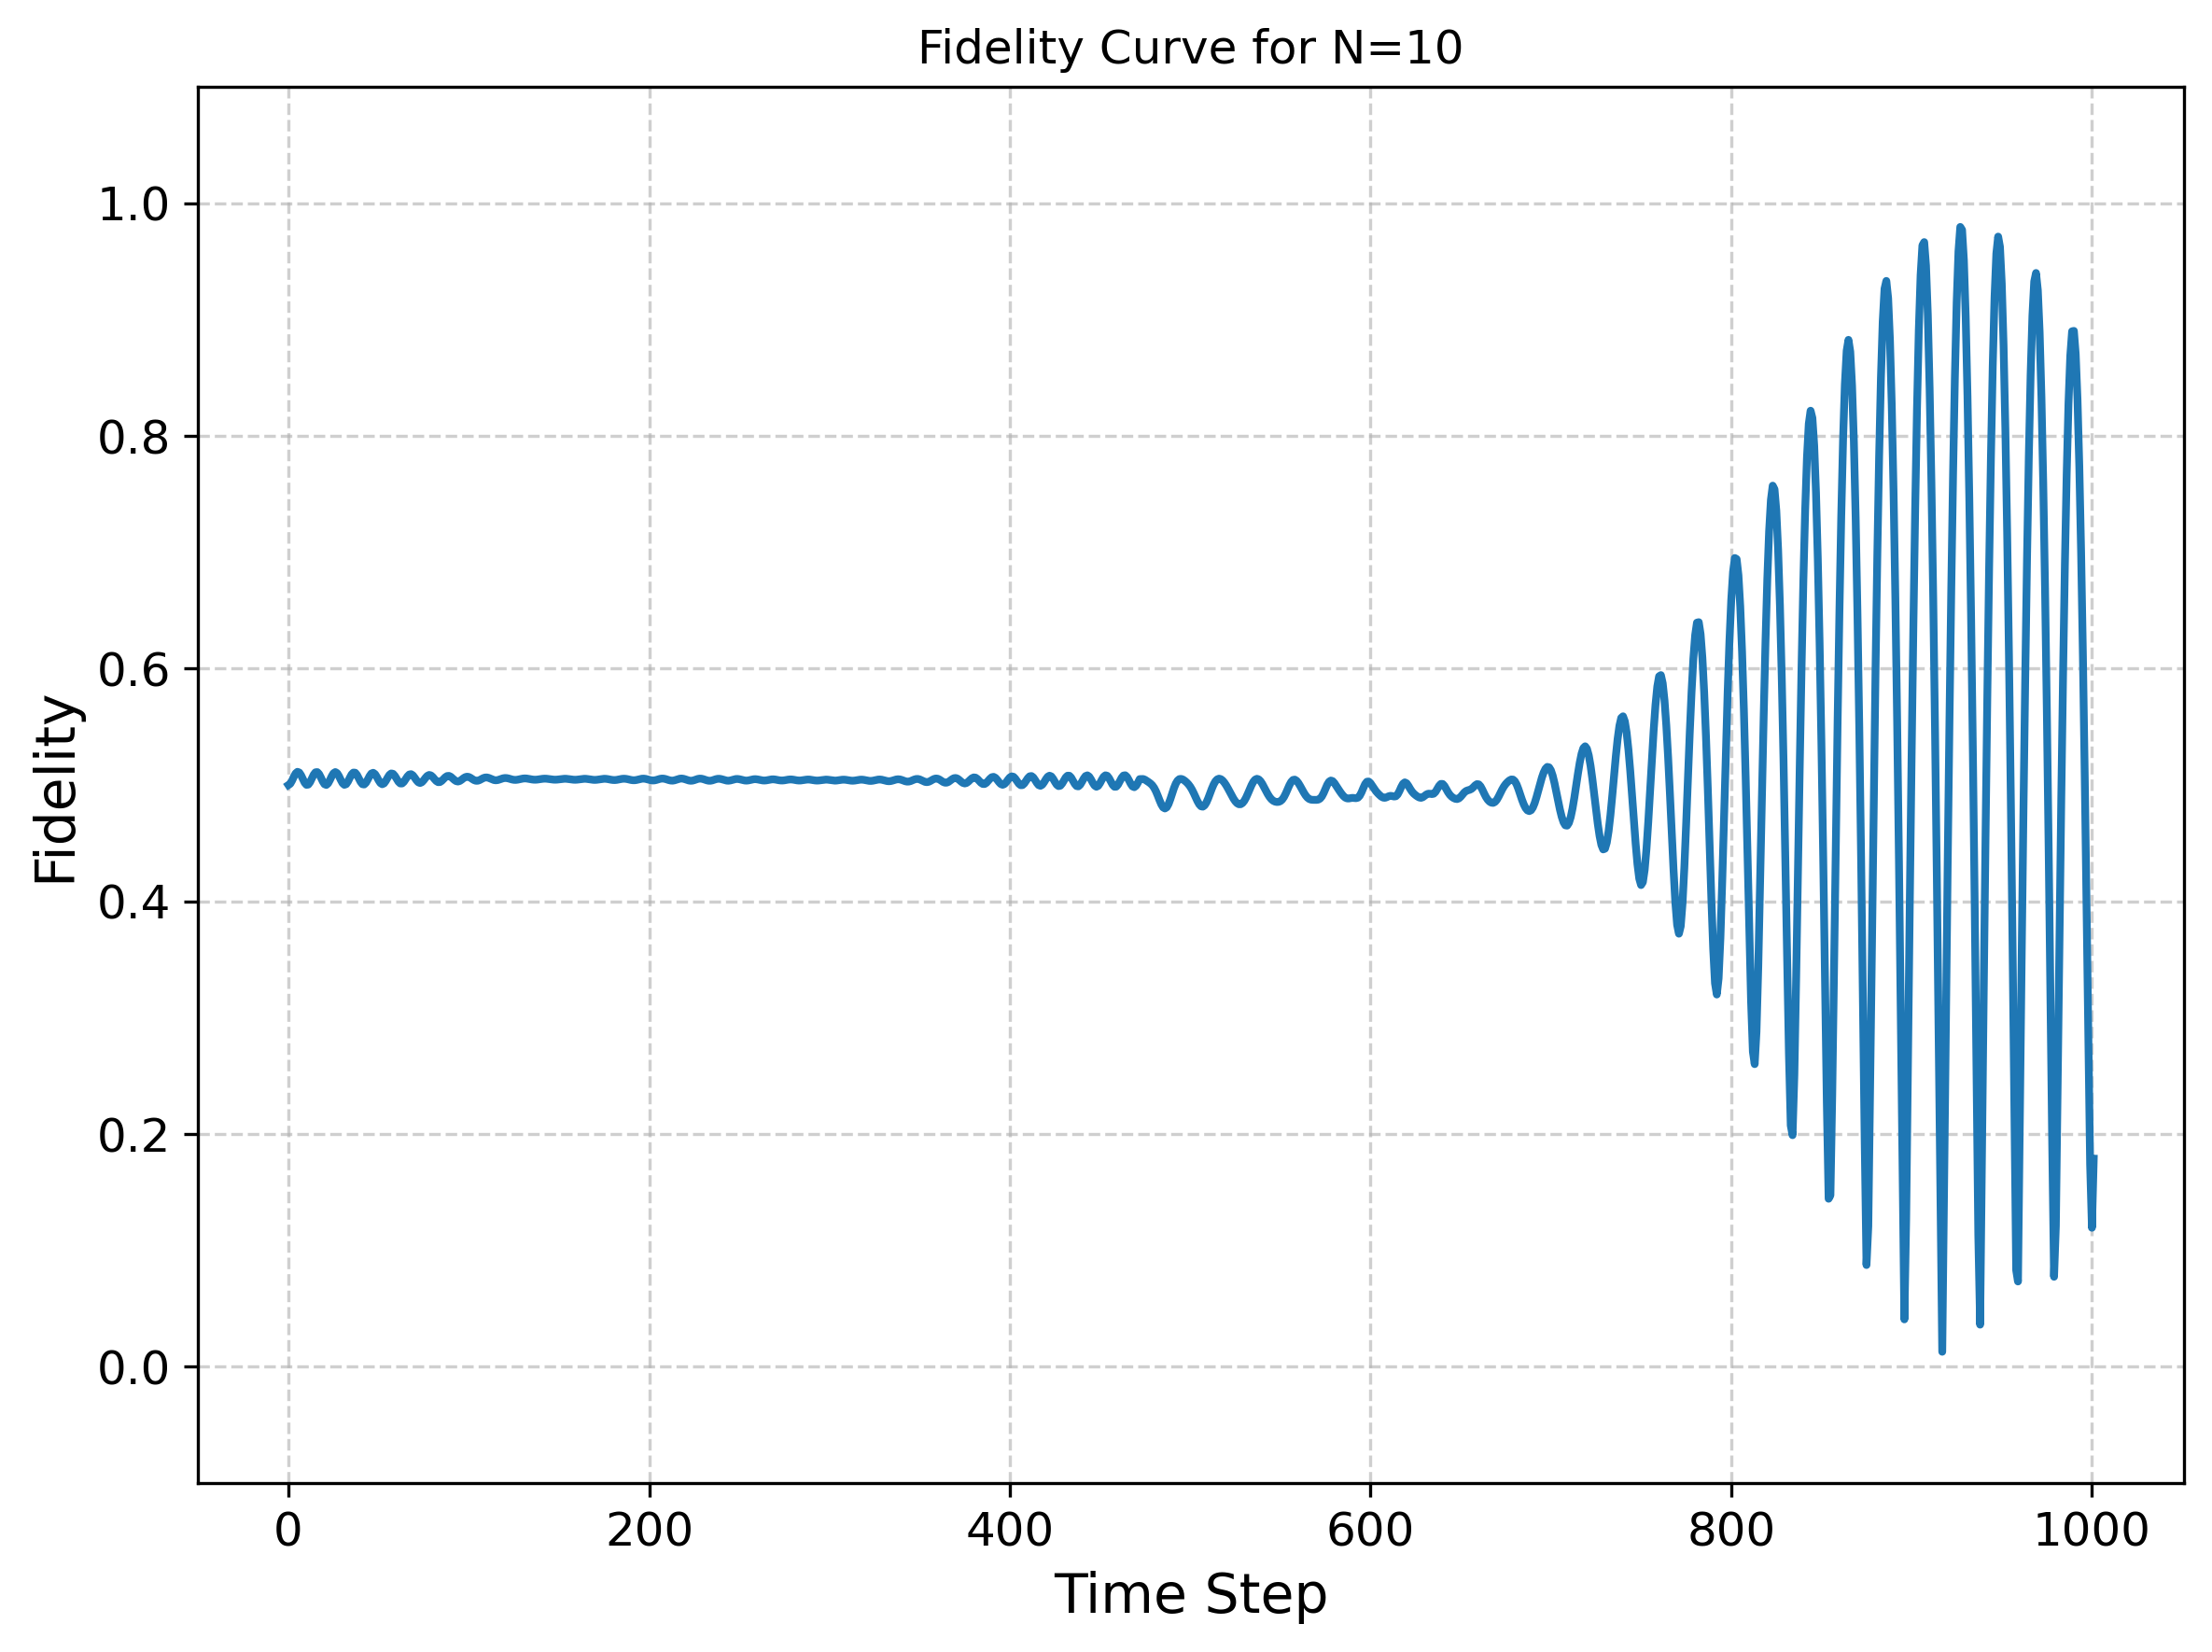

In [27]:
#Test plots
plots.plot_fidelity(fidelity, N)

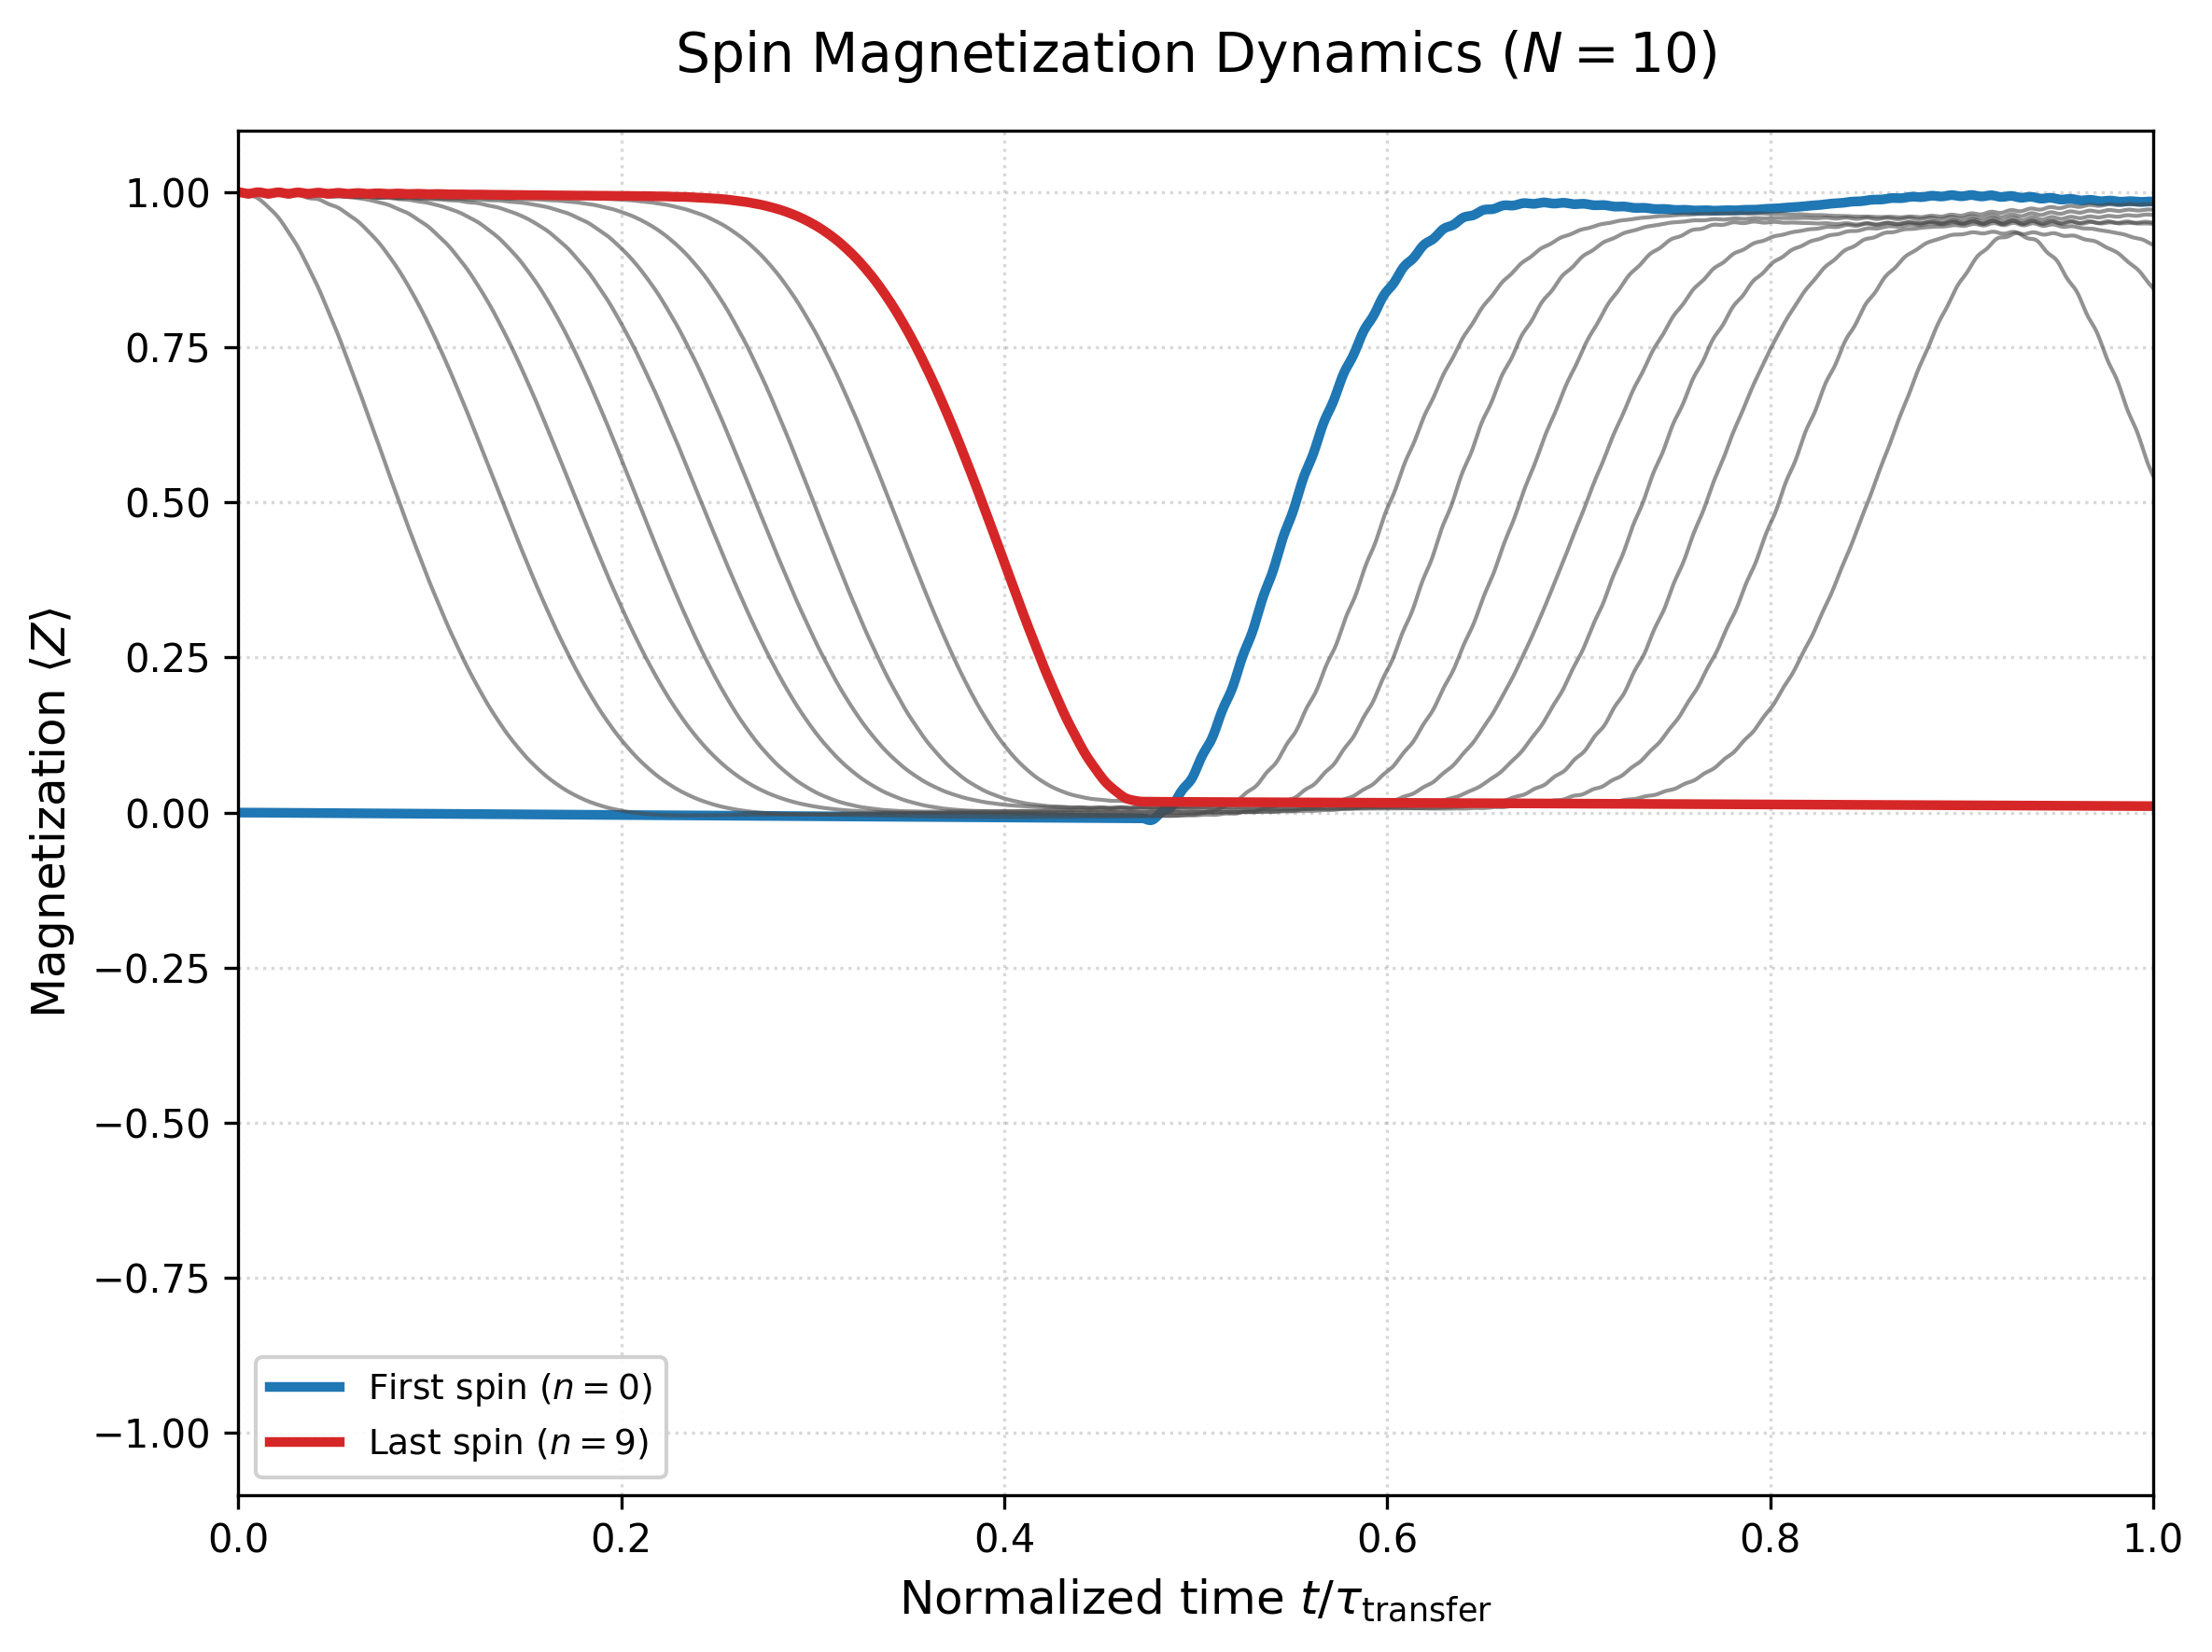

In [28]:
#Test plots
plots.plot_expectations(magnetizations["Sz"], N)

# Loop test

In [29]:
N=10
lmd = 0.02272
J = 0.05
state_dictionary = {"1":1}

ti = 0
tf = 150
Nsteps = 500

In [30]:
initial_state_DW, target_state_DW, register_size = md.create_DW_initial_and_target(state_dictionary, N, one_step = False)

In [31]:
# Define Hamiltonian without errors
H_t_noerror = Ham.Hamiltonian(system_size = N,
                    mode = "transport",
                    lambda_factor = lmd,
                    global_J = J
                    )

In [32]:
# Calibrate chain under ideal circumstances
transport_steps, transport_time = dyn.chain_calibration(initial_state_DW, H_t_noerror, ti, tf, Nsteps)

print(transport_steps, transport_time)

499 149.7


In [33]:
#    def __init__(self, system_size, mode, lambda_factor, register_size=None, global_J=None,
#                 j_error = None, z_error = None, l_error = None):


H_t = Ham.Hamiltonian(system_size = N,
                    mode = "transport",
                    lambda_factor = lmd,
                    global_J = J,
                    j_error = 0.00002,
                    l_error = 0.0005,
                    z_error = 0.0002
                    )
H_r = Ham.Hamiltonian(system_size = N,
                    mode = "reset",
                    lambda_factor = lmd,
                    register_size = register_size,
                    global_J = J,
                    j_error = 0.00002,
                    l_error = 0.0005,
                    z_error = 0.00002
                    )

#Main loop
fidelity = dyn.LightweightAlgorithm(initial_state_DW, target_state_DW, ti, transport_time, transport_steps, H_t, H_r)

print(fidelity)


0.3400299648998933


# Standard encoding

In [34]:
# Define parameters
N=11
lmd = 0.02272
J = 0.5

state_dictionary = {"1":1, "0":1}

ti = 0
tf = np.pi/lmd
Nsteps = 500

In [35]:
initial_state_ST, target_state_ST = md.create_ST_initial_and_target(state_dictionary, N)

# Standard version
H_s = Ham.Hamiltonian(system_size = N,
                    mode = "standard",
                    lambda_factor = lmd,
                    l_error = 0.001,
                    z_error = 0.005
                    )


In [36]:
# test that algorithm works well without errors
fidelity, magnetizations, corrected_fidelity = dyn.OneStepAlgorithm(initial_state_ST, target_state_ST, H_s, ti, tf, Nsteps, factor = 1.00)


print(max(fidelity))
print(fidelity[-1])

0.9671332163944679
0.9671332163944679


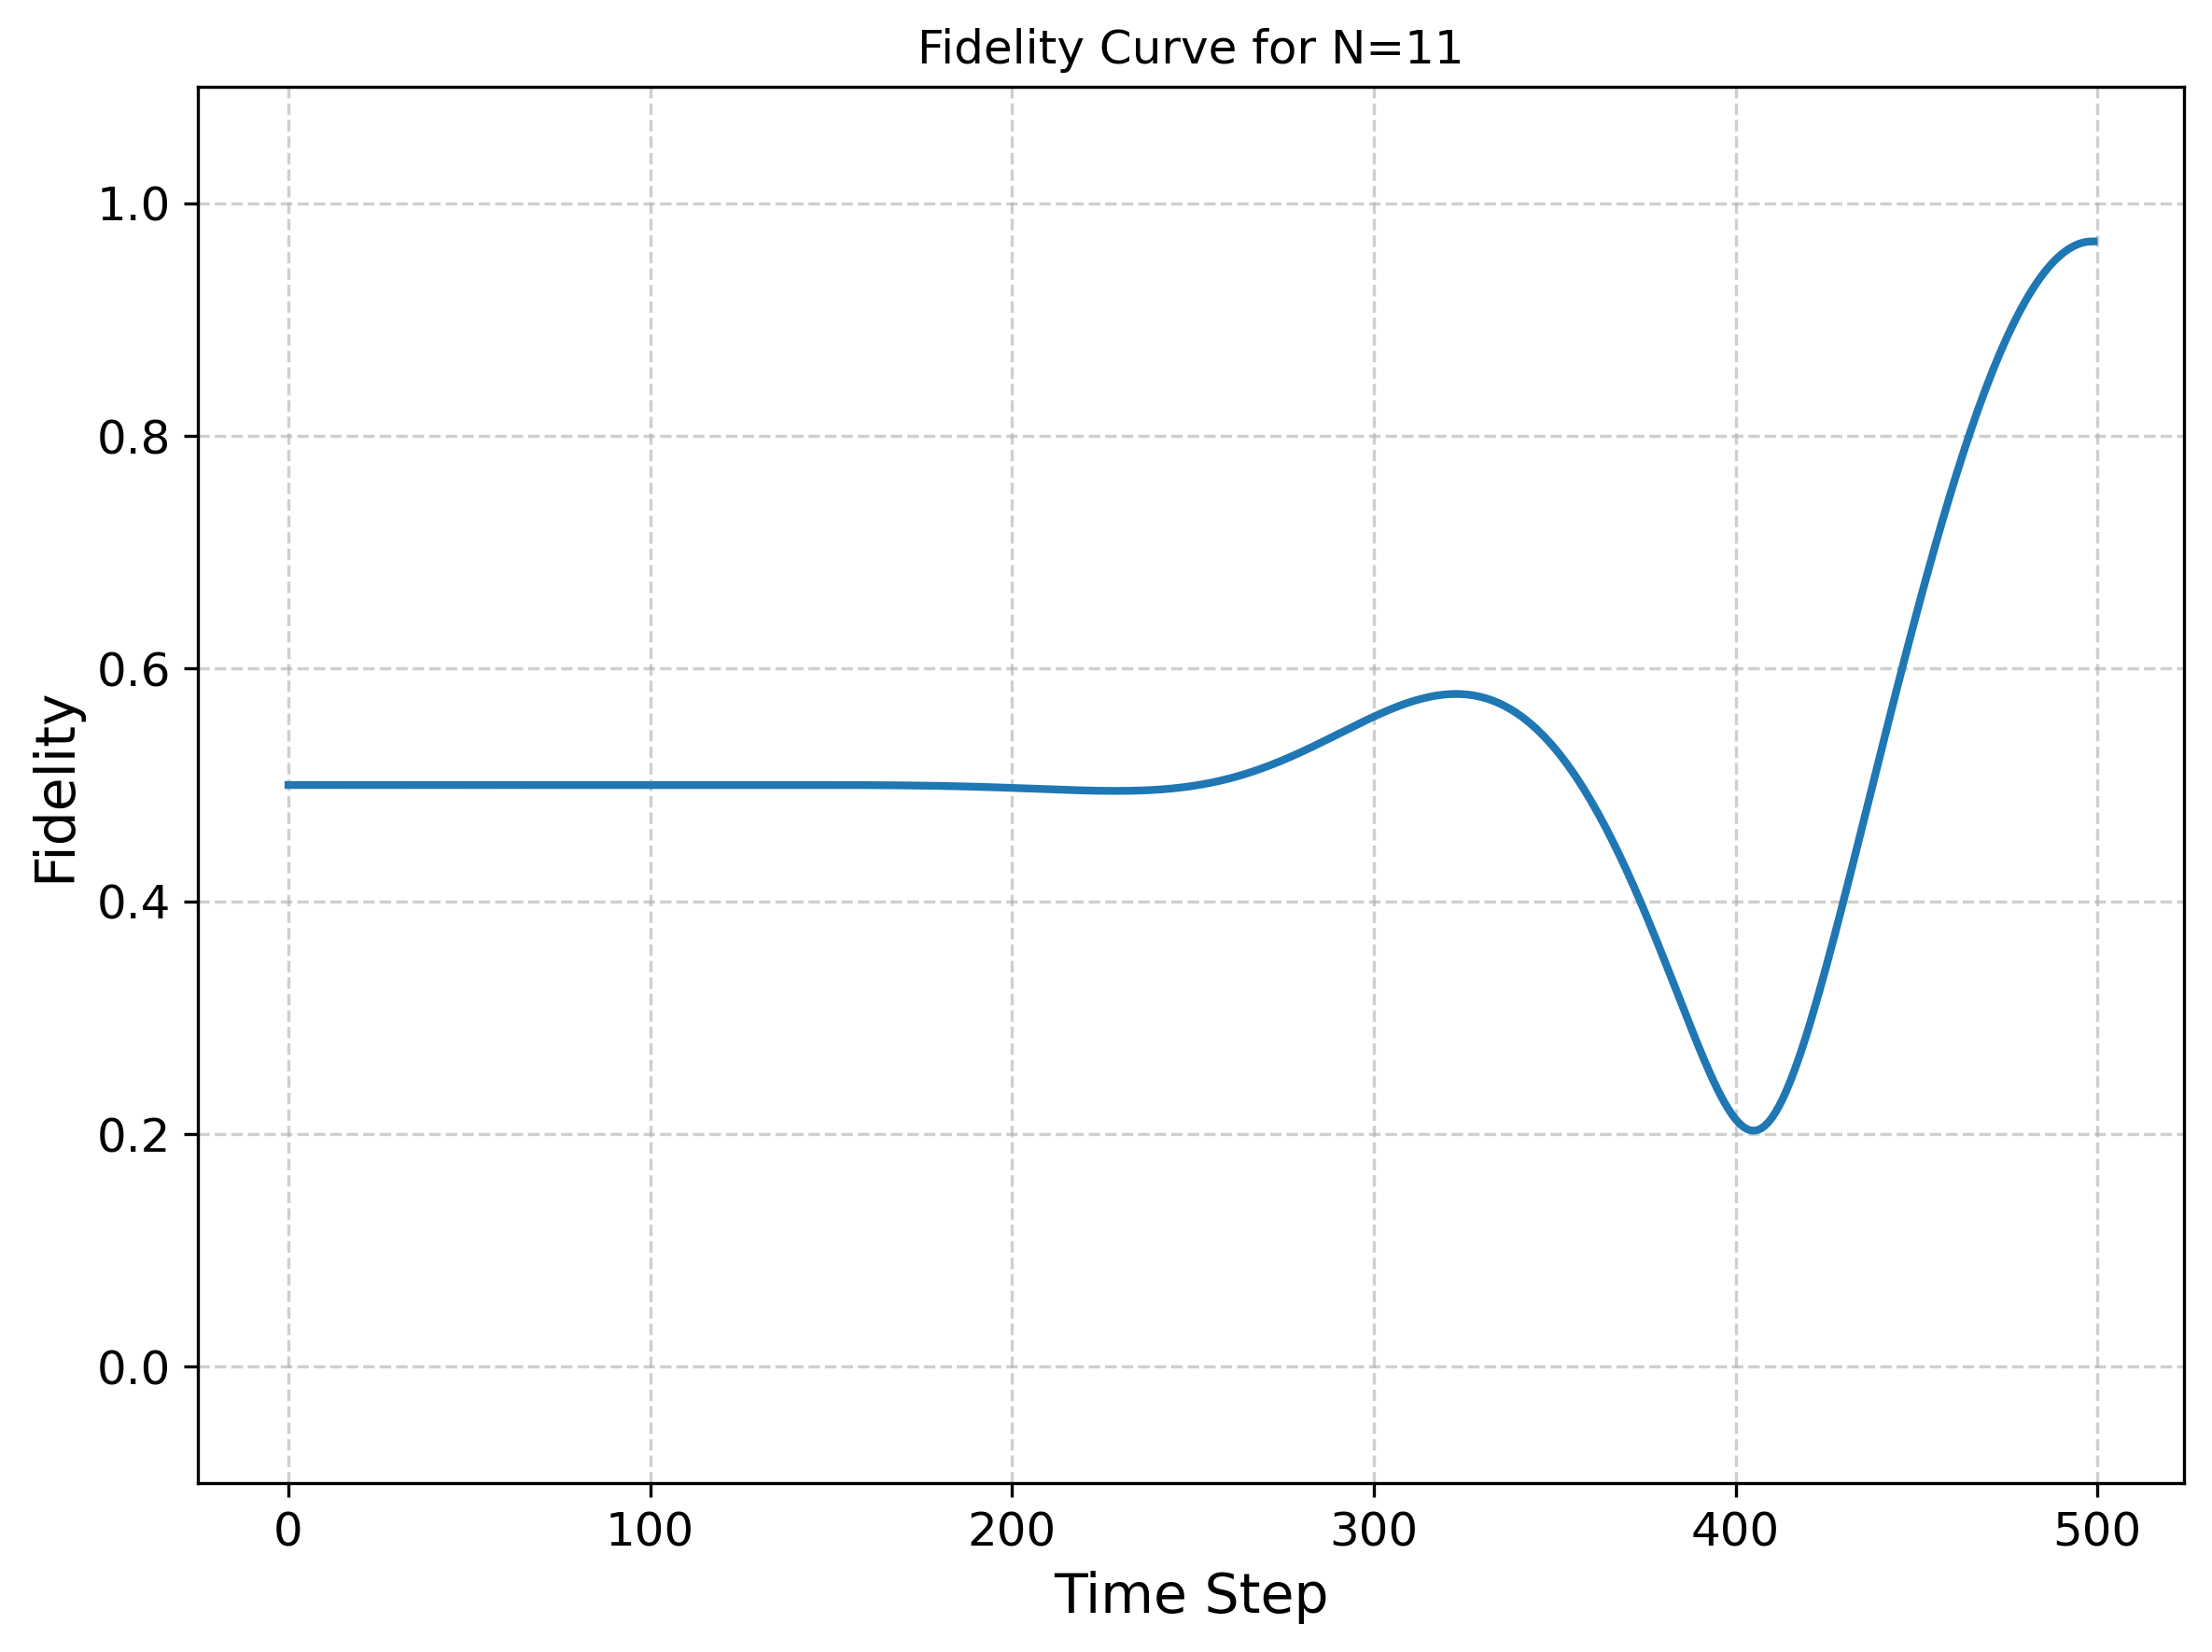

In [37]:
#Test plots
plots.plot_fidelity(fidelity, N)

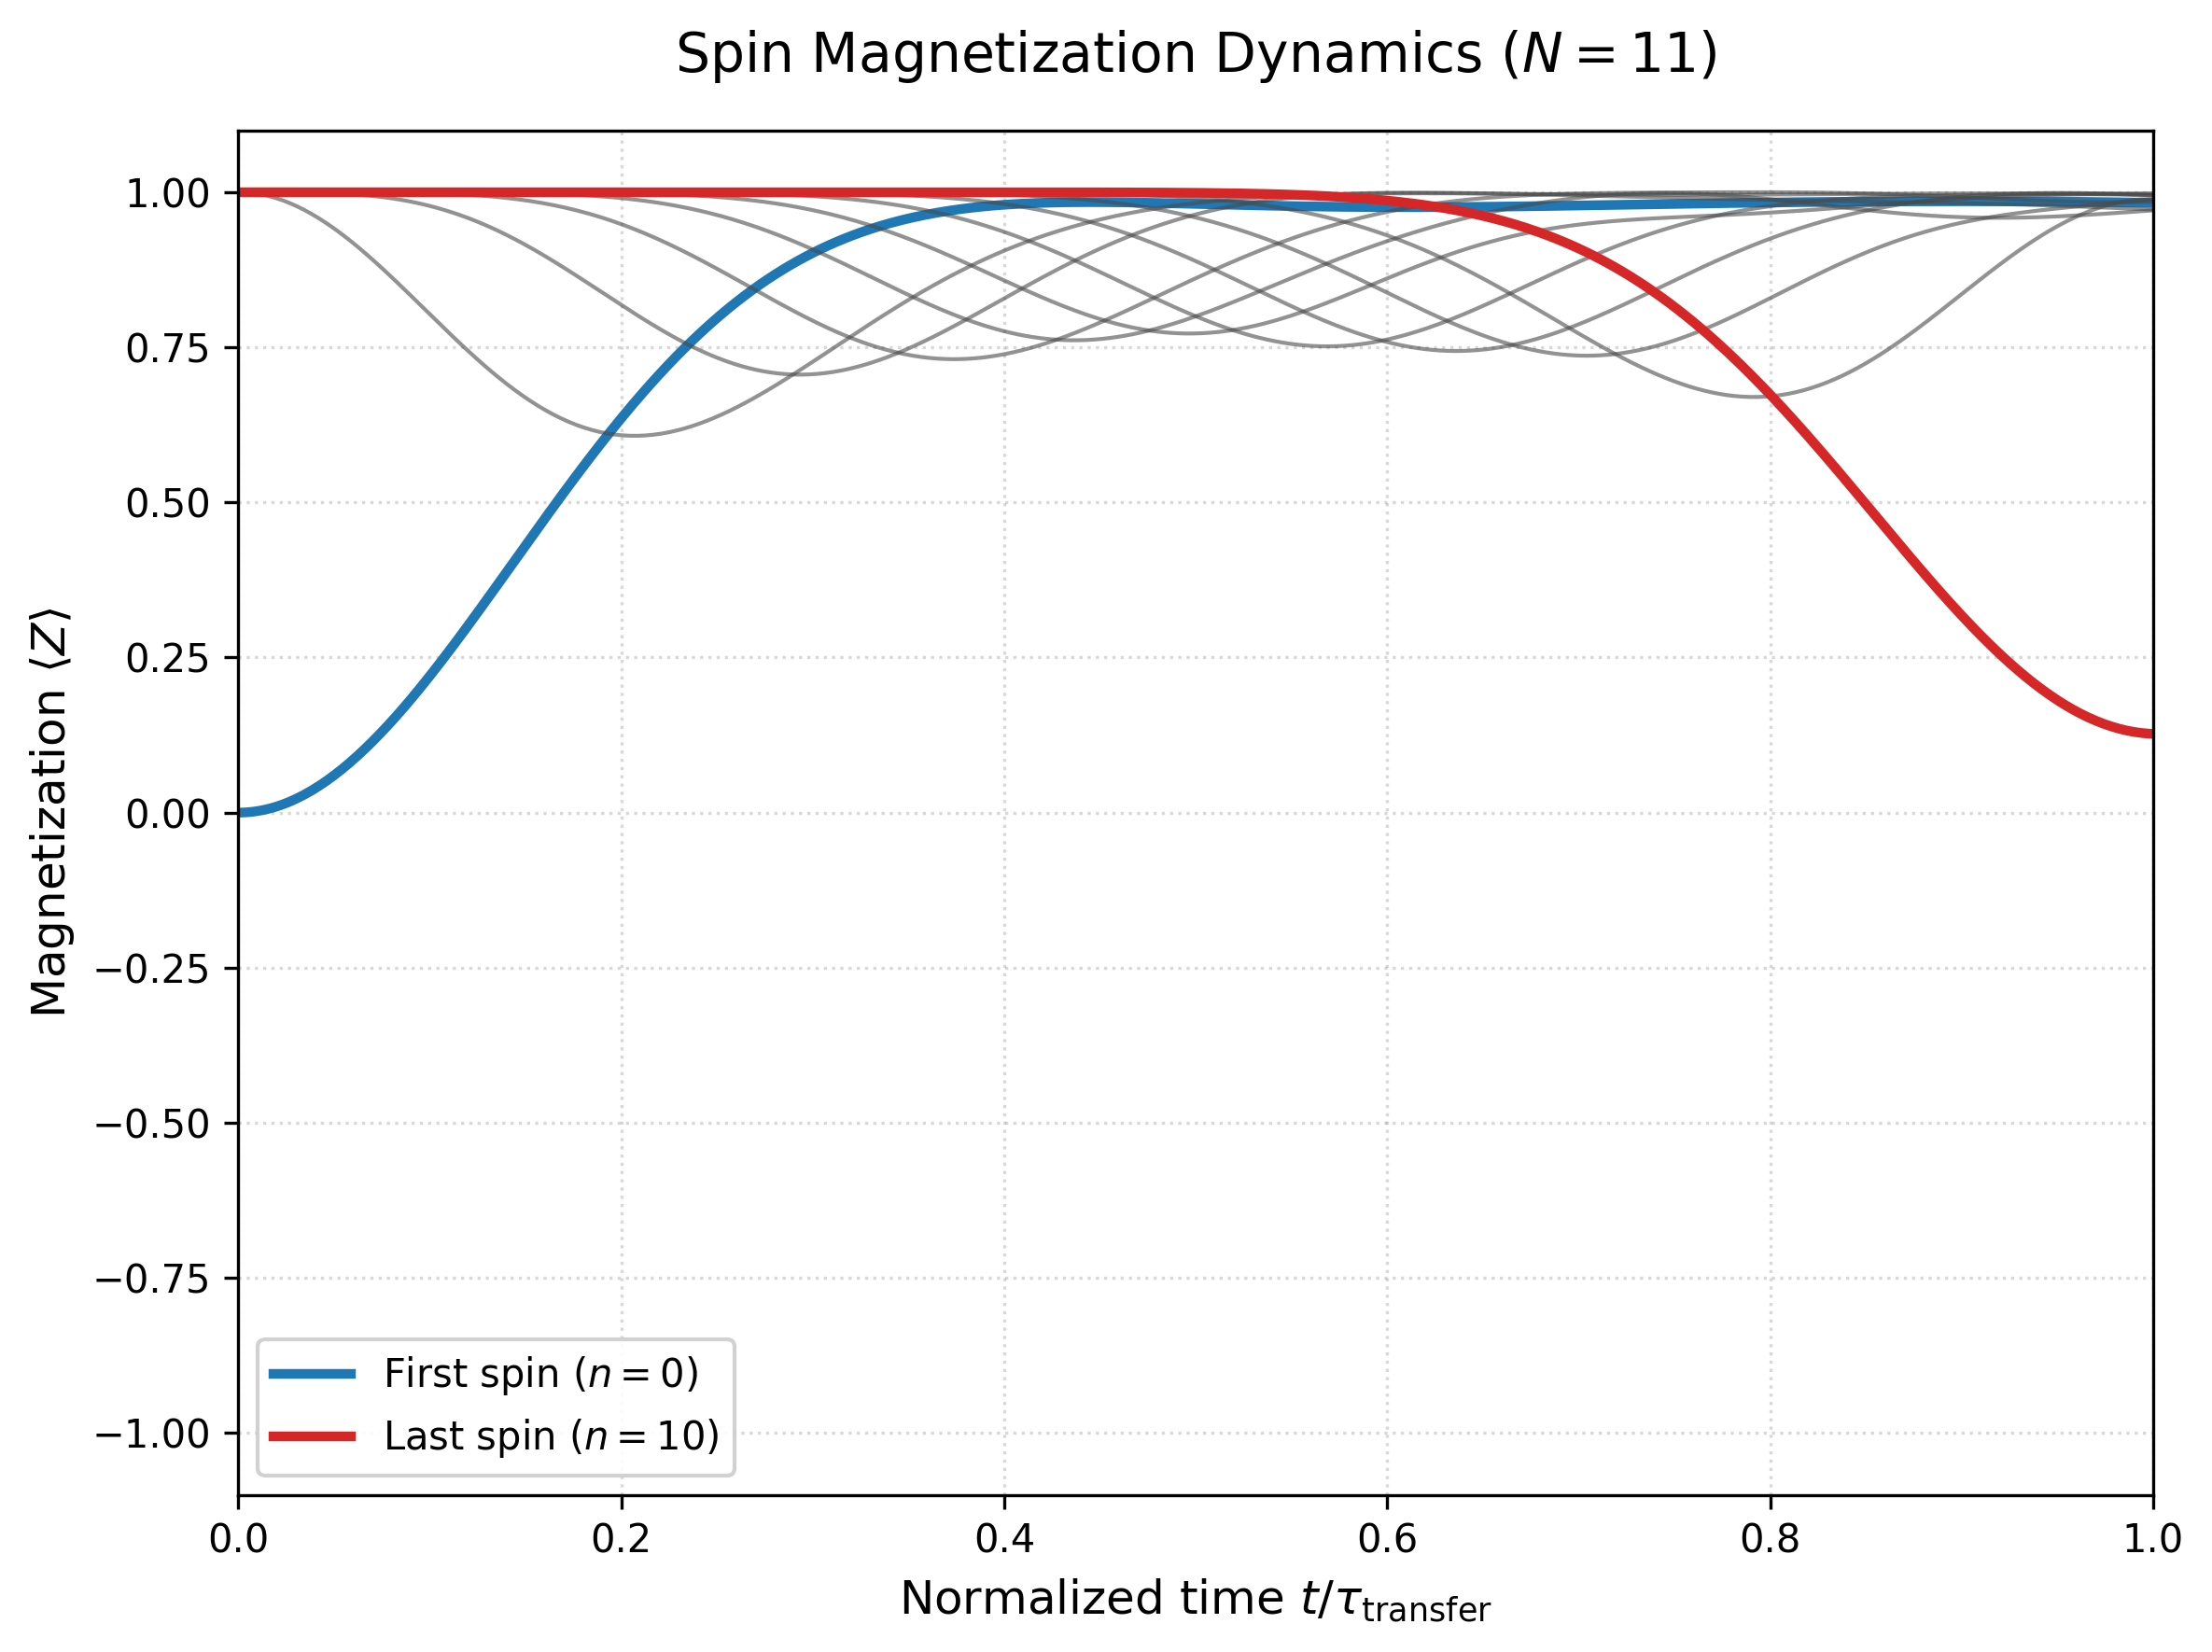

In [38]:
#Test plots
plots.plot_expectations(magnetizations["Sz"], N)